<a href="https://colab.research.google.com/github/Louis0117/XLNet/blob/master/XLNet_finetune_3class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### import&download data

In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
#!pip install transformers=='2.8.0'
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install transformers==2.9.0 
!pip install pytorch_lightning==0.7.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split


from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW

from tqdm import tqdm, trange
from sklearn.utils import shuffle
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
#% matplotlib inline

In [6]:
from google.colab import drive
# 將自己的雲端硬碟掛載上去
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### dataset

In [7]:
AXS_3class = pd.read_csv('/content/gdrive/MyDrive/XLNet/AXS_dataset_v10/AXS_data_3class_v10.csv',index_col=False)

In [8]:
sentences_3class = AXS_3class.text.values

In [9]:
# add special tokens
sentences_3class = [sentence + " [SEP] [CLS]" for sentence in sentences_3class]
# labels value
labels_3class = AXS_3class.label.values

In [10]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_3class = [tokenizer.tokenize(sent) for sent in sentences_3class]

In [11]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
MAX_LEN = 128

In [12]:
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
ids_3class = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_3class]

In [13]:
# Pad our input tokens
ids_3class = pad_sequences(ids_3class, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [14]:
# Create attention masks
attention_masks_3class = []

# Create a mask of 1s for each token followed by 0s for padding

for seq in ids_3class:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_3class.append(seq_mask)

In [15]:
# Use train_test_split to split our data into train and validation sets for training
# train_test_split from sklearn.model_selection

train_3class, test_3class, train_3class_labels, test_3class_labels = train_test_split(ids_3class, labels_3class, 
                                                            random_state=2018, test_size=0.2)

train_3class_masks, test_3class_masks, _, _ = train_test_split(attention_masks_3class, ids_3class,
                                             random_state=2018, test_size=0.2)

In [16]:
train_3class.shape

(3340, 128)

In [17]:
# Convert all of our data into torch tensors, the required datatype for our model
# 4 class dataset

train_3class = torch.tensor(train_3class)
test_3class = torch.tensor(test_3class)
train_3class_labels = torch.tensor(train_3class_labels)
test_3class_labels = torch.tensor(test_3class_labels)
train_3class_masks = torch.tensor(train_3class_masks)
test_3class_masks = torch.tensor(test_3class_masks)

In [18]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size =  32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data_3class = TensorDataset(train_3class, train_3class_masks, train_3class_labels)
train_sampler_3class = RandomSampler(train_data_3class)
train_dataloader_3class = DataLoader(train_data_3class, sampler=train_sampler_3class, batch_size=batch_size)

test_data_3class = TensorDataset(test_3class, test_3class_masks, test_3class_labels)
test_sampler_3class = RandomSampler(test_data_3class)
test_dataloader_3class = DataLoader(test_data_3class, sampler=test_sampler_3class, batch_size=batch_size)

### train model

In [19]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [20]:
model_3class_classifier = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=3)
model_3class_classifier.cuda()

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [21]:
param_optimizer = list(model_3class_classifier.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters_3class = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [22]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters_3class,
                     lr=2e-5)

In [23]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model_3class_classifier.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader_3class):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    #print(batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    #print(b_labels)
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model_3class_classifier(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model_3class_classifier.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in test_dataloader_3class:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model_3class_classifier(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss: 0.8229360472588312


Epoch:  25%|██▌       | 1/4 [01:47<05:22, 107.34s/it]

Validation Accuracy: 0.7164351851851852
Train loss: 0.5826607865946634


Epoch:  50%|█████     | 2/4 [03:33<03:33, 106.81s/it]

Validation Accuracy: 0.7442129629629629
Train loss: 0.46183474078064873


Epoch:  75%|███████▌  | 3/4 [05:20<01:46, 106.70s/it]

Validation Accuracy: 0.7615740740740741
Train loss: 0.32349806449243


Epoch: 100%|██████████| 4/4 [07:06<00:00, 106.72s/it]

Validation Accuracy: 0.7418981481481481


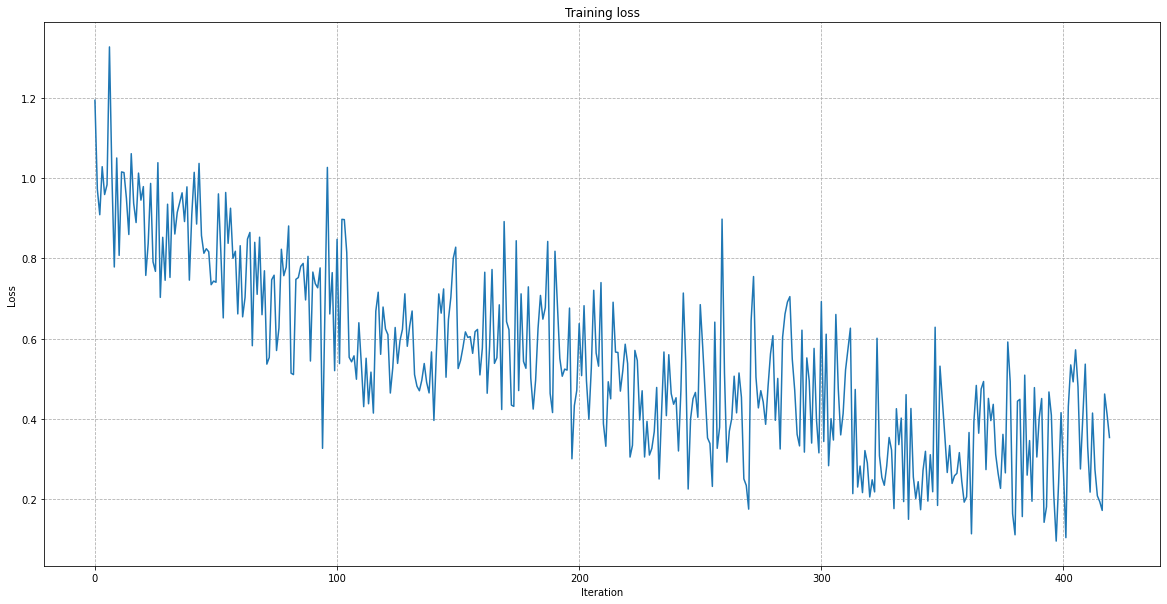

In [24]:
plt.figure(figsize=(20,10))
plt.title("Training loss")
plt.xlabel("lteration")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.grid(ls='--')
plt.show()

### testing

In [25]:
# Prediction on test set

# Put model in evaluation mode
model_3class_classifier.eval()
#model_3class_classifier
# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader_3class:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model_3class_classifier(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [26]:
predict = []
for i in range(len(predictions)):
  pred = np.argmax(predictions[i], axis=1).flatten()
  predict.append(pred)

In [27]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

micro_f1score = f1_score(flat_true_labels, flat_predictions, average='micro')
macro_f1score = f1_score(flat_true_labels, flat_predictions, average='macro')
#f1score3 = f1_score(actual, predicted, average='weighted')
confusion_matrix = confusion_matrix(flat_true_labels, flat_predictions)

In [29]:
micro_f1score

0.7332535885167463

In [30]:
macro_f1score

0.712198350109802

In [31]:
confusion_matrix

array([[358,  59,  79],
       [ 33, 121,   7],
       [ 34,  11, 134]])

### Reference  
https://mccormickml.com/2019/09/19/XLNet-fine-tuning/
